# Efficiency of Peak Detection Methods

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%%capture
import sys
sys.path.insert(0, '/home/raf_pc/Kemal/RiboSeqAnalysis')
from infrastructure.main import *

temp_repo_dir = "/home/raf_pc/Kemal/Temp/mouse"
data_repo_dir = "/home/raf_pc/Kemal/Data/sam_arpat"
script_path_infrastructure = "/home/raf_pc/Kemal/RiboSeqAnalysis/infrastructure/"

disomes = [os.path.join(data_repo_dir, i) for i in ["SRR9715828.sam", "SRR9715826.sam"]]
monosomes = [os.path.join(data_repo_dir, i) for i in ["SRR1930189.sam", "SRR1930188.sam"]]


I = Infrastructre(temp_repo_dir,
                  riboseq_assign_at=-15,
                  riboseq_assign_to="best_transcript",
                  ensembl_release=102,
                  organism="mus_musculus",
                  include_gene3d=True,
                  verbose=True)

I.riboseq_sixtymers = RiboSeqSixtymers(I.temp_repo_dir, monosomes, disomes, "sixtymers",
                                       I.riboseq_assign_at, I.riboseq_assign_to,
                                       I.protein_genome, I.gene_info,
                                       exclude_genes=I.exclude_genes, verbose=I.verbose,
                                       footprint_len_experiment=list(range(45,71)),  # From paper
                                       footprint_len_translatome=list(range(26,36))  # From paper
                                       )

In [3]:
import shutil
def cleartarget(dir_path):
    """
    Delete everything in the output folder
    :param dir_path: Path of directory to delete
    :return: None. Creates new one with the same name
    """
    try:
        shutil.rmtree(dir_path)
    except FileNotFoundError:
        pass
    os.mkdir(dir_path)
figure_dir = os.path.join(temp_repo_dir, "jupyter_figures_peak_detection_methods_comparison")
cleartarget(figure_dir)
os.chdir(figure_dir)

## Amino Acid Windows

In [4]:
from functools import partial
from copy import deepcopy

window_len = 181
window_flank = int(np.floor(window_len / 2))
percentiles = (60, 70, 80, 85, 90, 92.5, 95, 97.5, 99)
probabilities = (0.120, 0.080, 0.050, 0.025, 0.0175, 0.010, 0.004, 0.0025, 0.001)
assert window_len % 2 == 1 and window_len >= 3
assert len(percentiles) == len(probabilities)

# Methods
inecik1 = partial(I.riboseq_sixtymers.stalling_peaks_inecik_1, window="hanning", window_len=25, min_rpkm_sixtymers=-1, min_rpkm_translatome=1)
inecik2 = partial(I.riboseq_sixtymers.stalling_peaks_inecik_2, window="hanning", window_len=25, wlen=300, min_rpkm_sixtymers=-1, min_rpkm_translatome=1)
inecik3 = partial(I.riboseq_sixtymers.stalling_peaks_inecik_3, window="hanning", window_len=25, wlen=300, min_rpkm_sixtymers=-1, min_rpkm_translatome=1)
inecik4 = partial(I.riboseq_sixtymers.stalling_peaks_inecik_4, window="hanning", window_len=25, wlen=300, min_rpkm_sixtymers=-1, min_rpkm_translatome=1)
arpat = partial(I.riboseq_sixtymers.stalling_peaks_arpat, mmc_threshold=1, normalized_peak_count_thr=5, get_top=5)

save_metadata_path = os.path.join(temp_repo_dir, "jupyter_method_comparison_protein_sequences_params_percentile.joblib")
try:  # Because it takes very long, as written very inefficiently.
    W = joblib.load(save_metadata_path)
except FileNotFoundError:

    ci = [[] for _ in range(len(percentiles))]
    windows = [deepcopy(ci), deepcopy(ci), deepcopy(ci), deepcopy(ci), [], []]  # inecik1, inecik2, inecik3, inecik4, arpat, monte_carlo

    for ind, gene_id in enumerate(I.gene_list):
        progress_bar(ind, len(I.gene_list) - 1, verbose=True)
        best_transcript = I.gene_info[gene_id].transcripts.iloc[0][0]  # At least 1 transcript exists
        protein_sequence = I.protein_genome.db[best_transcript][1]
        length_protein = len(protein_sequence)
        assert "." not in protein_sequence
        protein_sequence = "." * window_flank + protein_sequence + "." * window_flank
        # My methods
        for param1 in range(len(percentiles)):
            peaks1 = (np.floor(inecik1(gene_id, percentile=percentiles[param1]) / 3) + window_flank).astype(int)
            peaks2 = (np.floor(inecik2(gene_id, percentile=percentiles[param1]) / 3) + window_flank).astype(int)
            peaks3 = (np.floor(inecik3(gene_id, probability=probabilities[param1]) / 3) + window_flank).astype(int)
            peaks4 = (np.floor(inecik4(gene_id, percentile=percentiles[param1]) / 3) + window_flank).astype(int)
            for inecik_method, peaks in zip(range(4), [peaks1, peaks2, peaks3, peaks4]):
                for peak in peaks:
                    windows[inecik_method][param1].append(protein_sequence[peak - window_flank: peak + window_flank + 1])
        # Arpat
        peaks5 = (np.floor(arpat(gene_id) / 3) + window_flank).astype(int)
        for peak in peaks5:
            windows[4].append(protein_sequence[peak - window_flank: peak + window_flank + 1])
        # Monte Carlo
        peaks_mc = (np.sort(np.random.choice(length_protein, 10)) + window_flank).astype(int)
        for peak in peaks_mc:
            windows[5].append(protein_sequence[peak - window_flank: peak + window_flank + 1])        

    ci = [None for _ in range(len(percentiles))]
    W = [deepcopy(ci), deepcopy(ci), deepcopy(ci), deepcopy(ci), None, None]  # inecik1, inecik2, inecik3, inecik4, arpat, monte_carlo

    for inecik_method in range(4):
        for param1 in range(len(percentiles)):
            W_temp = np.chararray((len(windows[inecik_method][param1]), window_len), itemsize=1)
            W_temp[:] = "."
            for ind, peak_window in enumerate(windows[inecik_method][param1]):
                W_temp[ind] = list(peak_window)
            W[inecik_method][param1] = W_temp
    for other_method in range(4, 6):
        W_temp = np.chararray((len(windows[other_method]), window_len), itemsize=1)
        W_temp[:] = "."
        for ind, peak_window in enumerate(windows[other_method]):
            W_temp[ind] = list(peak_window)
        W[other_method] = W_temp

    del windows
    joblib.dump(W, save_metadata_path)

## Charge

In [5]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Inecik Methods
charges = list()
for k in range(4):
    charges_method = list()
    for i in range(len(percentiles)):
        charges_temp = list()
        W_temp = W[k][i].T
        for j in range(window_len):
            aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "")
            pa = ProteinAnalysis(aminoacids_vertical)
            average_charge = pa.charge_at_pH(7) / len(aminoacids_vertical)
            charges_temp.append(average_charge)
        charges_method.append(charges_temp)
    charges.append(charges_method)
# Arpat & Monte Carlo
for k in range(4, 6):
    charges_temp = list()
    W_temp = W[k].T
    for j in range(window_len):
        aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "")
        pa = ProteinAnalysis(aminoacids_vertical)
        average_charge = pa.charge_at_pH(7) / len(aminoacids_vertical)
        charges_temp.append(average_charge)
    charges.append(charges_temp)

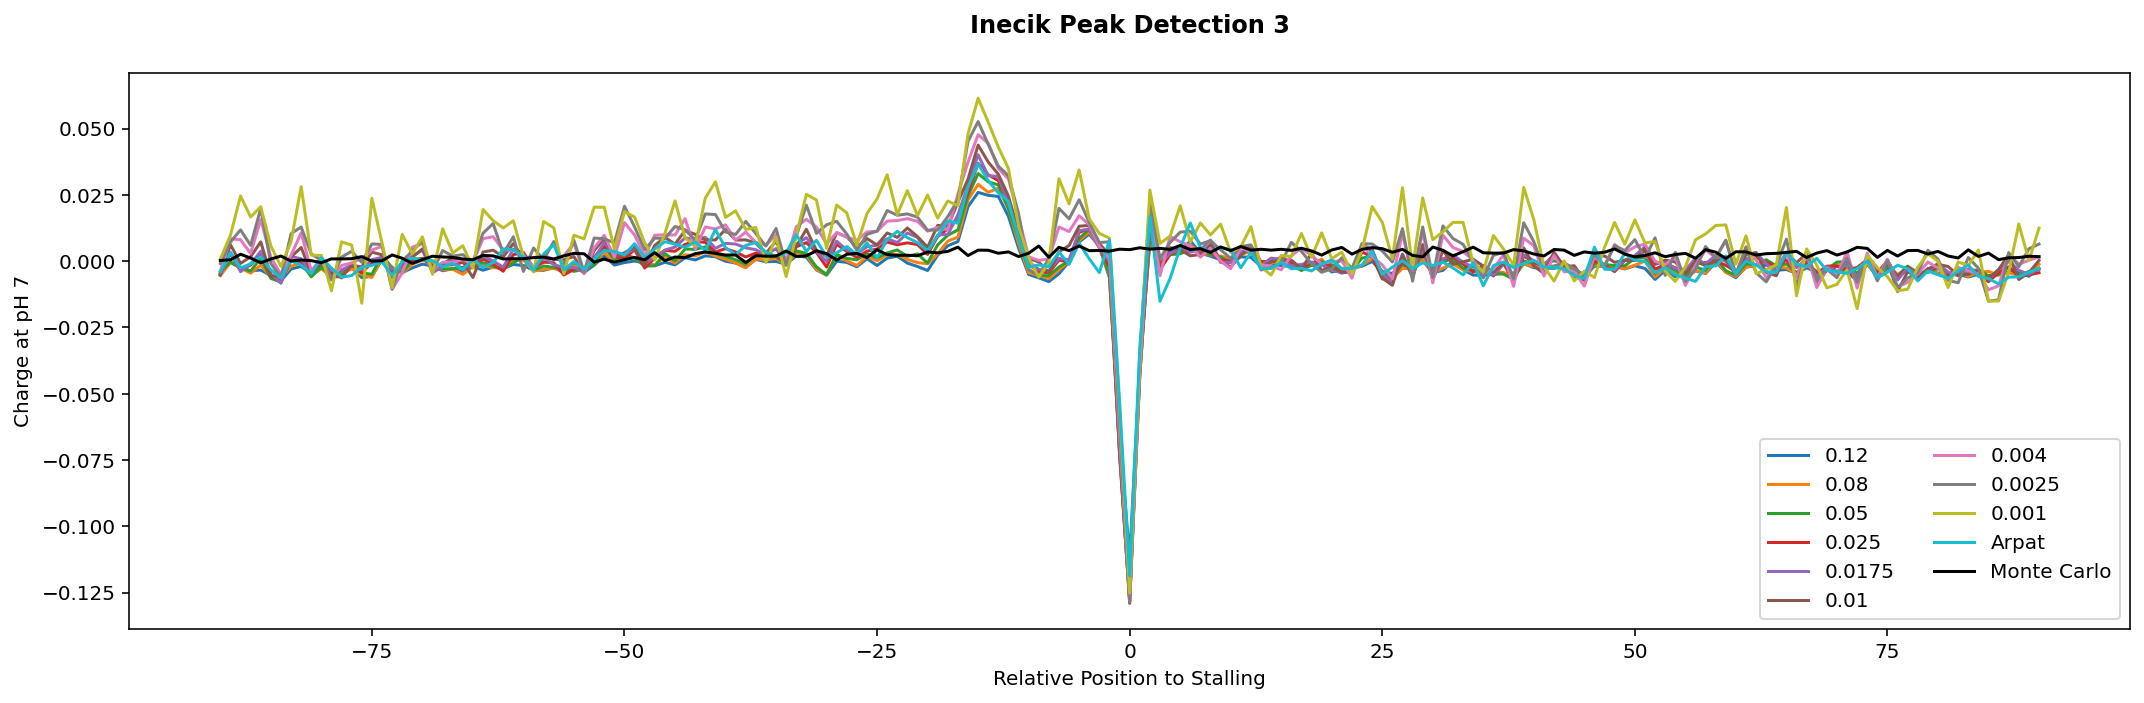

In [6]:
m = 2
fig = plt.figure(figsize=(15,5))
x=np.arange(-window_flank, window_flank + 1)
for i in range(len(percentiles)):
    plt.plot(x, charges[m][i], label=percentiles[i] if m!=2 else probabilities[i])
plt.plot(x, charges[4], label="Arpat")
plt.plot(x, charges[5], label="Monte Carlo", color="black")
plt.legend(loc="lower right", ncol=2)
plt.title(f"Inecik Peak Detection {m+1}", y=1.05, fontweight="bold")
plt.xlabel("Relative Position to Stalling")
plt.ylabel("Charge at pH 7")
plt.tight_layout()
plt.savefig("Charge_window.pdf")
plt.show()

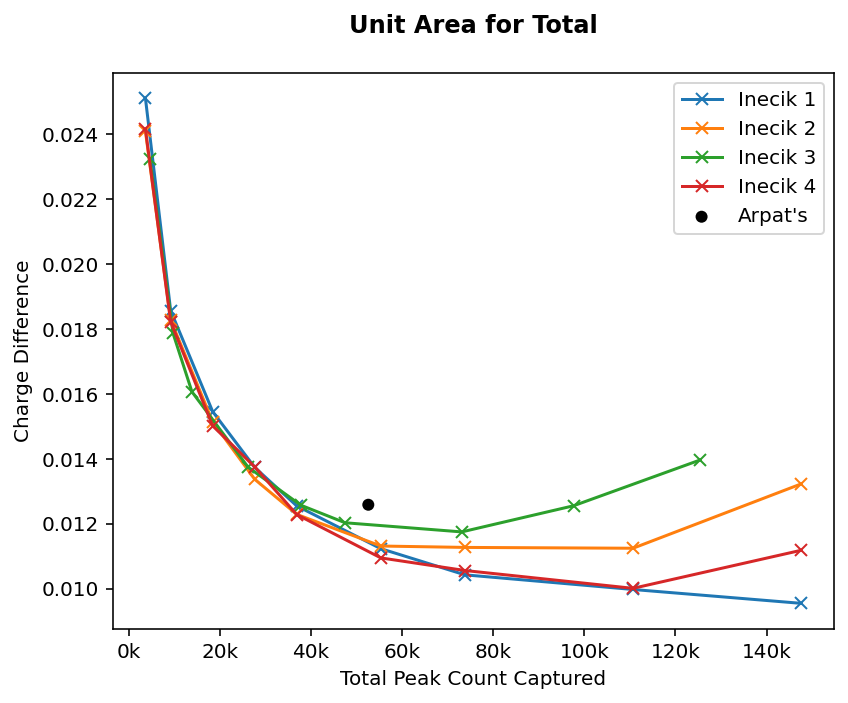

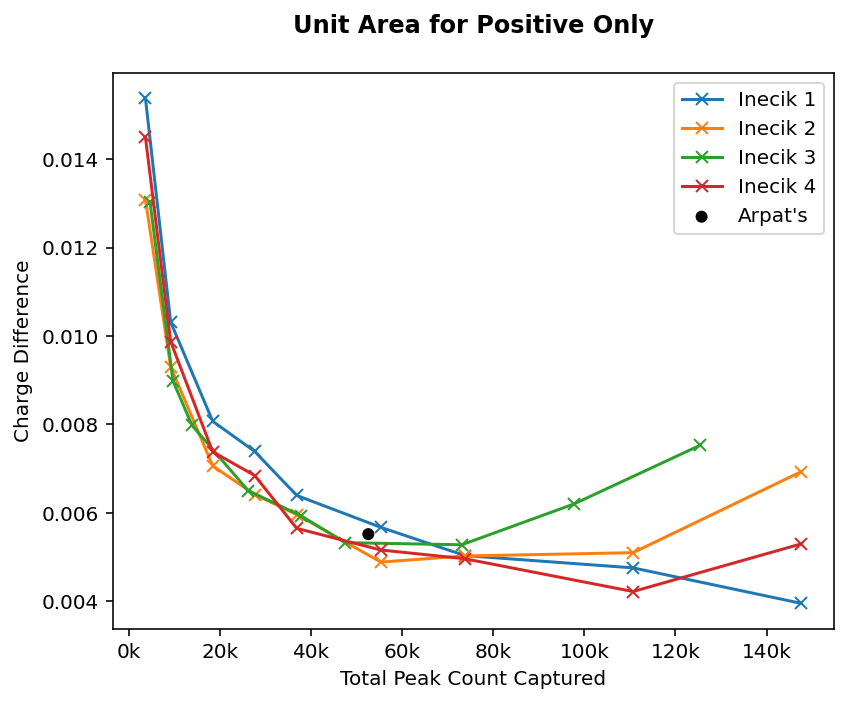

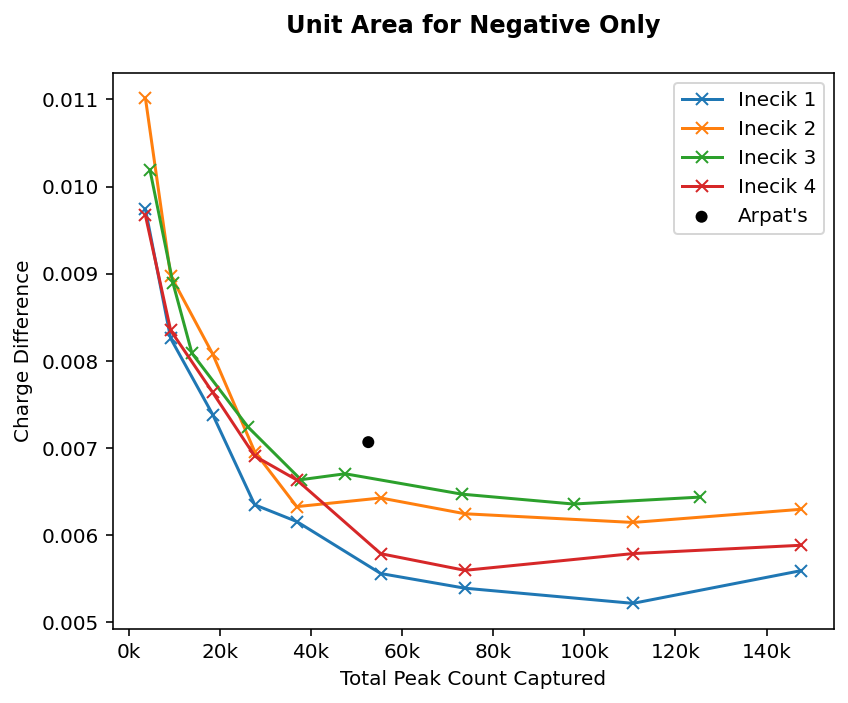

In [7]:
def objective_function(x1, x2, method):
    diff = np.array(x1) - np.array(x2) # calculate difference
    posPart = np.maximum(diff, 0) # only keep positive part, set other values to zero
    negPart = -np.minimum(diff, 0) # only keep negative part, set other values to zero    
    posAreaRatio = np.trapz(posPart) / np.sum(diff > 0)
    negAreaRatio = np.trapz(negPart) / np.sum(diff < 0)
    if method == "Total":
        return posAreaRatio + negAreaRatio
    elif method == "Positive Only":
        return posAreaRatio
    elif method == "Negative Only":
        return negAreaRatio

for method in ["Total", "Positive Only", "Negative Only"]:
    of = partial(objective_function, method=method)
    fig = plt.figure(figsize=(6, 5))
    for m in range(4):
        lengths = [len(W[m][i]) for i in range(len(percentiles))]
        score = [of(charges[m][k], np.array(charges[5])) for k in range(len(percentiles))]
        plt.plot(lengths, score, marker="x", label=f"Inecik {m+1}")
    arpat_score = of(charges[4], charges[5])
    arpat_length = len(W[4])
    plt.scatter(arpat_length, arpat_score, edgecolors="None", label="Arpat's", color="black")
    plt.title(f"Unit Area for {method}", y=1.05, fontweight="bold")
    plt.xlabel("Total Peak Count Captured")
    plt.ylabel("Charge Difference")
    plt.gca().set_xticklabels(['{:,.0f}'.format(x) + 'k' for x in plt.gca().get_xticks()/1000])
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"Unit_Area_for_{method}.pdf")
    plt.show()
    

## The grand average of hydropathy (GRAVY) value 

In [8]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Inecik Methods
gravy_scores = list()
for k in range(4):
    gravy_method = list()
    for i in range(len(percentiles)):
        gravy_temp = list()
        W_temp = W[k][i].T
        for j in range(window_len):
            aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
            pa = ProteinAnalysis(aminoacids_vertical)
            average_gravy = pa.gravy()
            gravy_temp.append(average_gravy)
        gravy_method.append(gravy_temp)
    gravy_scores.append(gravy_method)
# Arpat & Monte Carlo
for k in range(4, 6):
    gravy_temp = list()
    W_temp = W[k].T
    for j in range(window_len):
        aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
        pa = ProteinAnalysis(aminoacids_vertical)
        average_gravy = pa.gravy()
        gravy_temp.append(average_gravy)
    gravy_scores.append(gravy_temp)

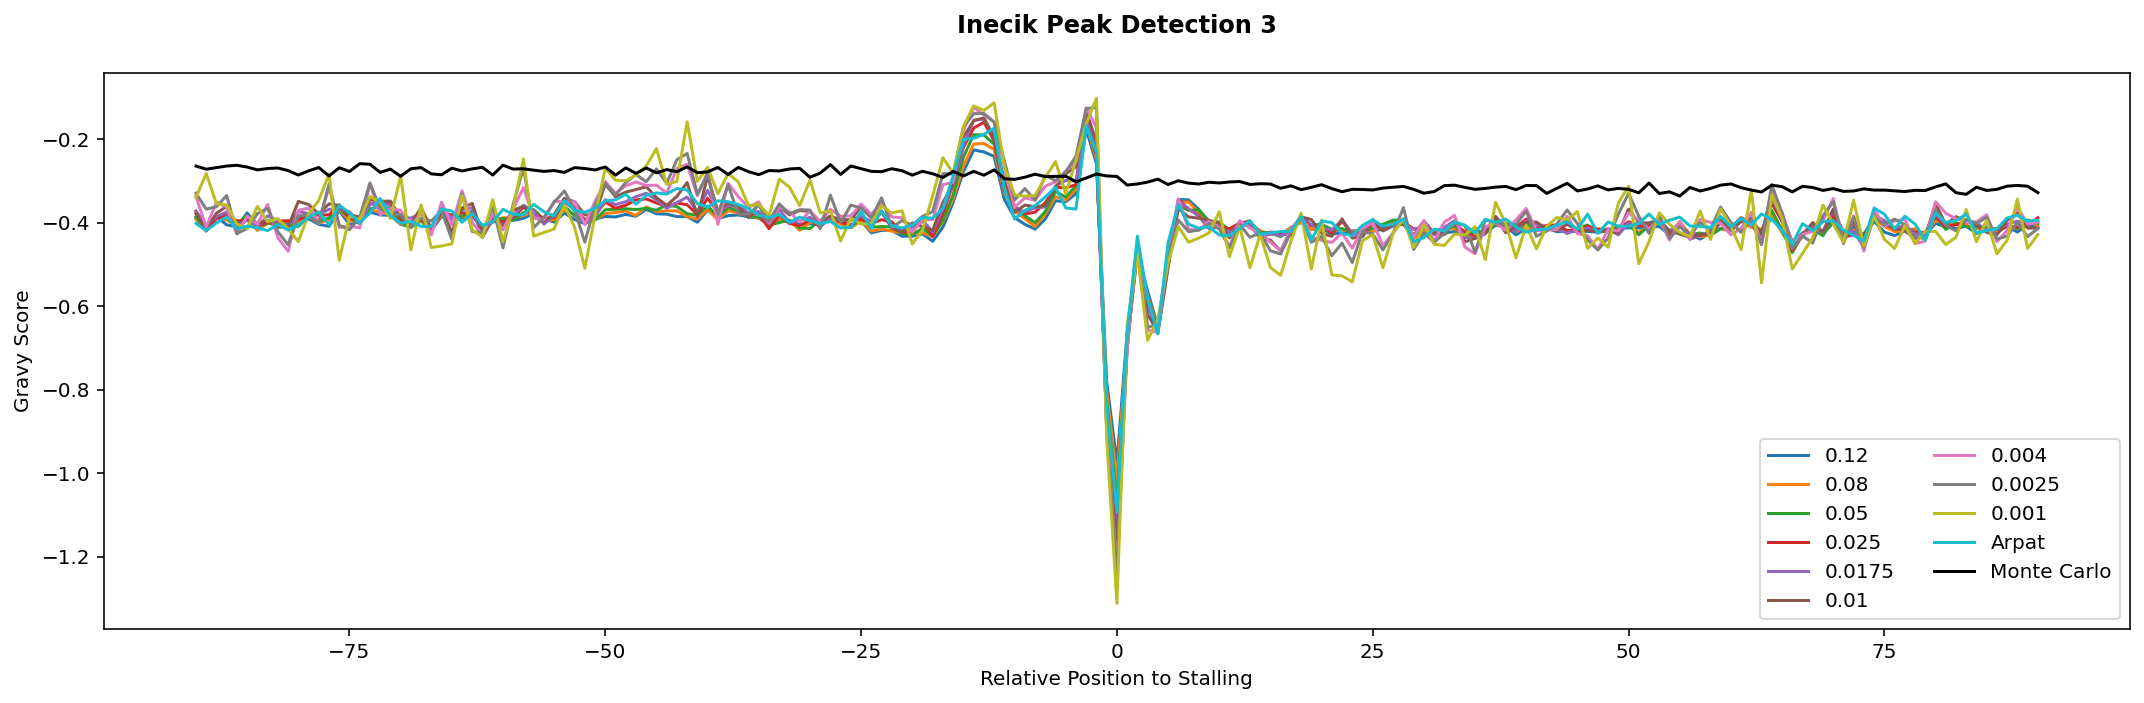

In [9]:
m = 2
fig = plt.figure(figsize=(15,5))
x=np.arange(-window_flank, window_flank + 1)
for i in range(len(percentiles)):
    plt.plot(x, gravy_scores[m][i], label=percentiles[i] if m!=2 else probabilities[i])
plt.plot(x, gravy_scores[4], label="Arpat")
plt.plot(x, gravy_scores[5], label="Monte Carlo", color="black")
plt.legend(loc="lower right", ncol=2)
plt.title(f"Inecik Peak Detection {m+1}", y=1.05, fontweight="bold")
plt.xlabel("Relative Position to Stalling")
plt.ylabel("Gravy Score")
plt.tight_layout()
plt.savefig("Gravy_window.pdf")
plt.show()

## Molecular Weight

In [10]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Inecik Methods
molwei = list()
for k in range(4):
    molwei_method = list()
    for i in range(len(percentiles)):
        molwei_temp = list()
        W_temp = W[k][i].T
        for j in range(window_len):
            aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
            pa = ProteinAnalysis(aminoacids_vertical)
            average_mw = pa.molecular_weight() / len(aminoacids_vertical)
            molwei_temp.append(average_mw)
        molwei_method.append(molwei_temp)
    molwei.append(molwei_method)
# Arpat & Monte Carlo
for k in range(4, 6):
    molwei_temp = list()
    W_temp = W[k].T
    for j in range(window_len):
        aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
        pa = ProteinAnalysis(aminoacids_vertical)
        average_mw = pa.molecular_weight() / len(aminoacids_vertical)
        molwei_temp.append(average_mw)
    molwei.append(molwei_temp)

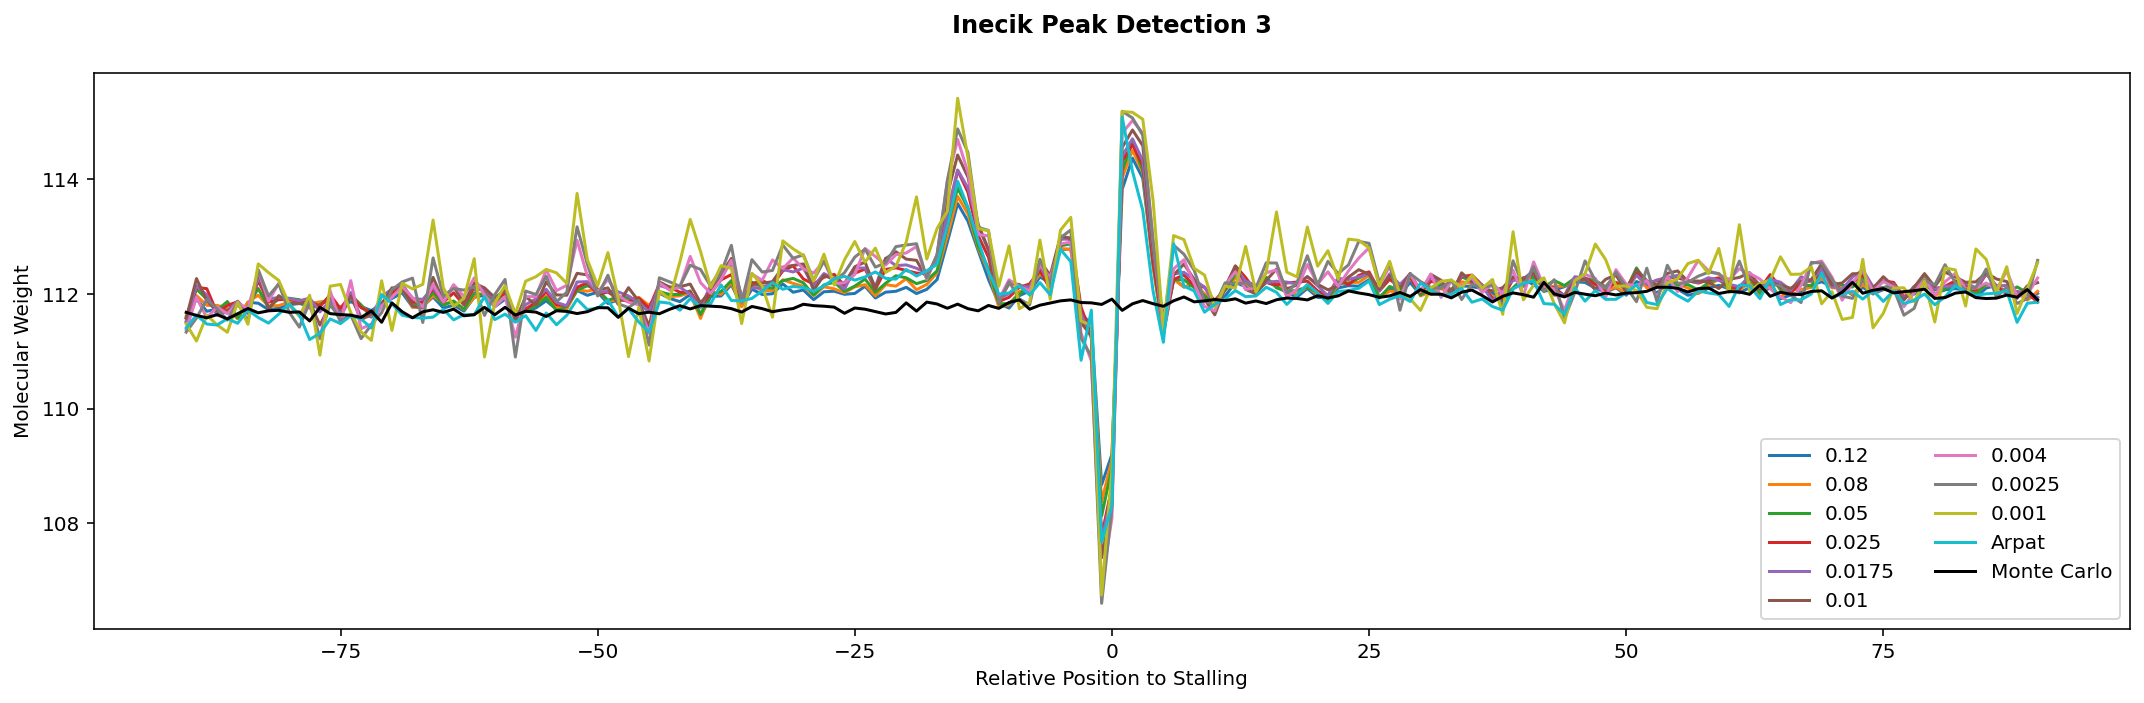

In [11]:
m = 2
fig = plt.figure(figsize=(15,5))
x=np.arange(-window_flank, window_flank + 1)
for i in range(len(percentiles)):
    plt.plot(x, molwei[m][i], label=percentiles[i] if m!=2 else probabilities[i])
plt.plot(x, molwei[4], label="Arpat")
plt.plot(x, molwei[5], label="Monte Carlo", color="black")
plt.legend(loc="lower right", ncol=2)
plt.title(f"Inecik Peak Detection {m+1}", y=1.05, fontweight="bold")
plt.xlabel("Relative Position to Stalling")
plt.ylabel("Molecular Weight")
plt.tight_layout()
plt.savefig("Molecular_Weight_window.pdf")
plt.show()

## Secondary Structure Fraction

In [12]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Inecik Methods
ssf = list()
for k in range(4):
    ssf_method = list()
    for i in range(len(percentiles)):
        ssf_temp = list()
        W_temp = W[k][i].T
        for j in range(window_len):
            aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
            pa = ProteinAnalysis(aminoacids_vertical)
            average_ssf = pa.secondary_structure_fraction()
            ssf_temp.append(average_ssf)
        ssf_method.append(ssf_temp)
    ssf.append(ssf_method)
# Arpat & Monte Carlo
for k in range(4, 6):
    ssf_temp = list()
    W_temp = W[k].T
    for j in range(window_len):
        aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
        pa = ProteinAnalysis(aminoacids_vertical)
        average_ssf = pa.secondary_structure_fraction()
        ssf_temp.append(average_ssf)
    ssf.append(ssf_temp)

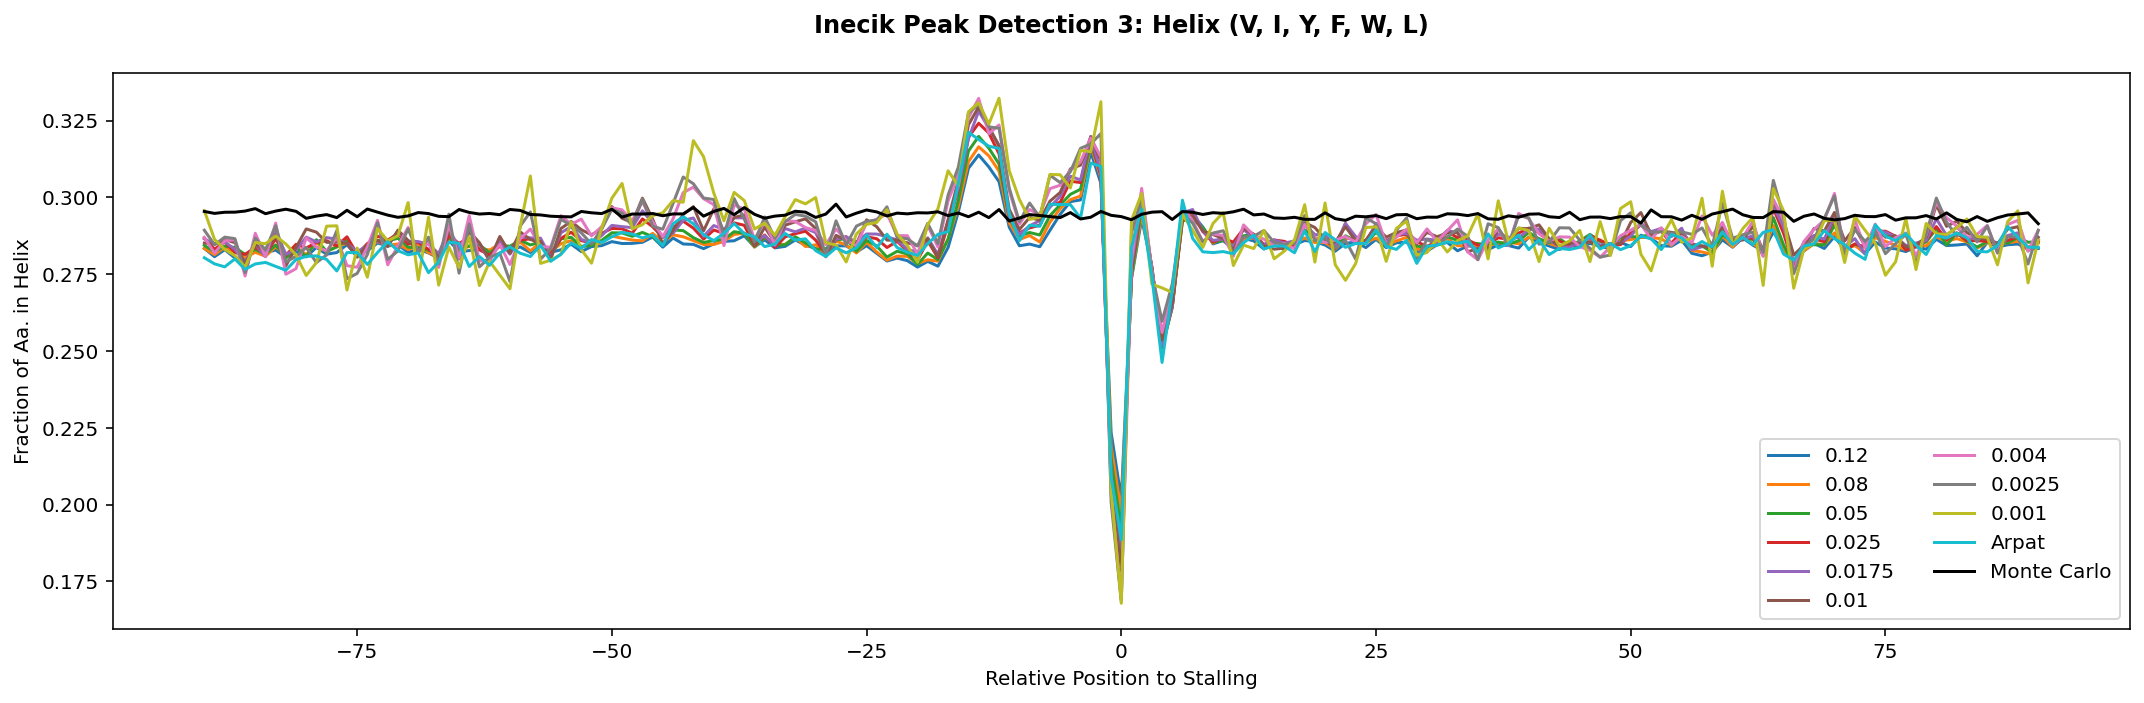

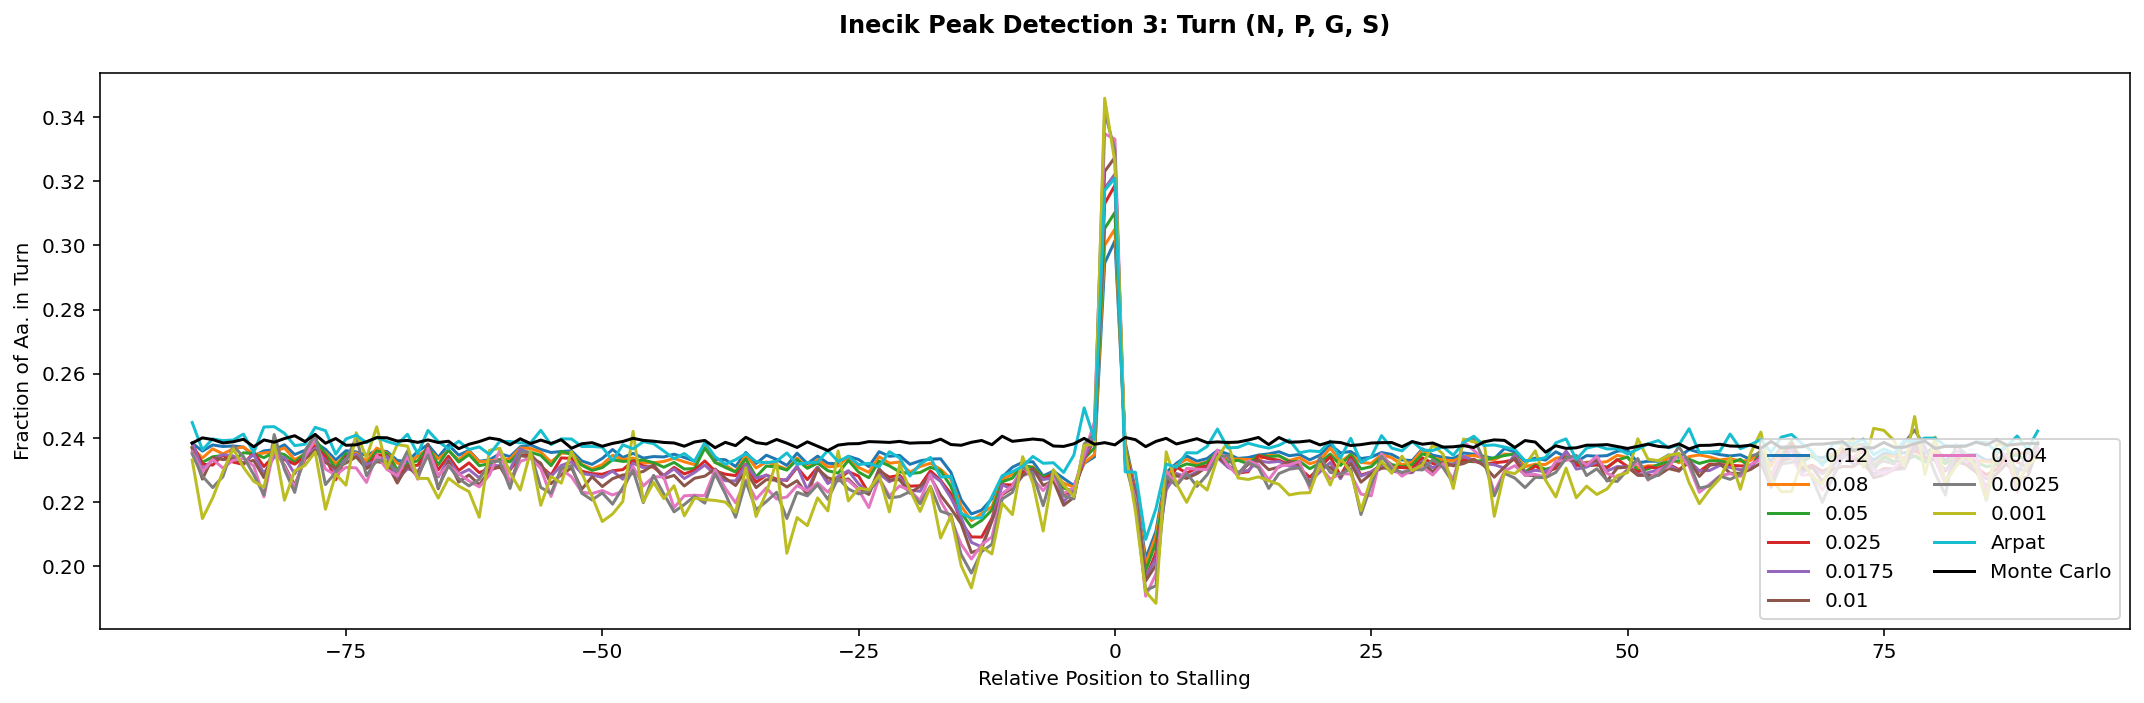

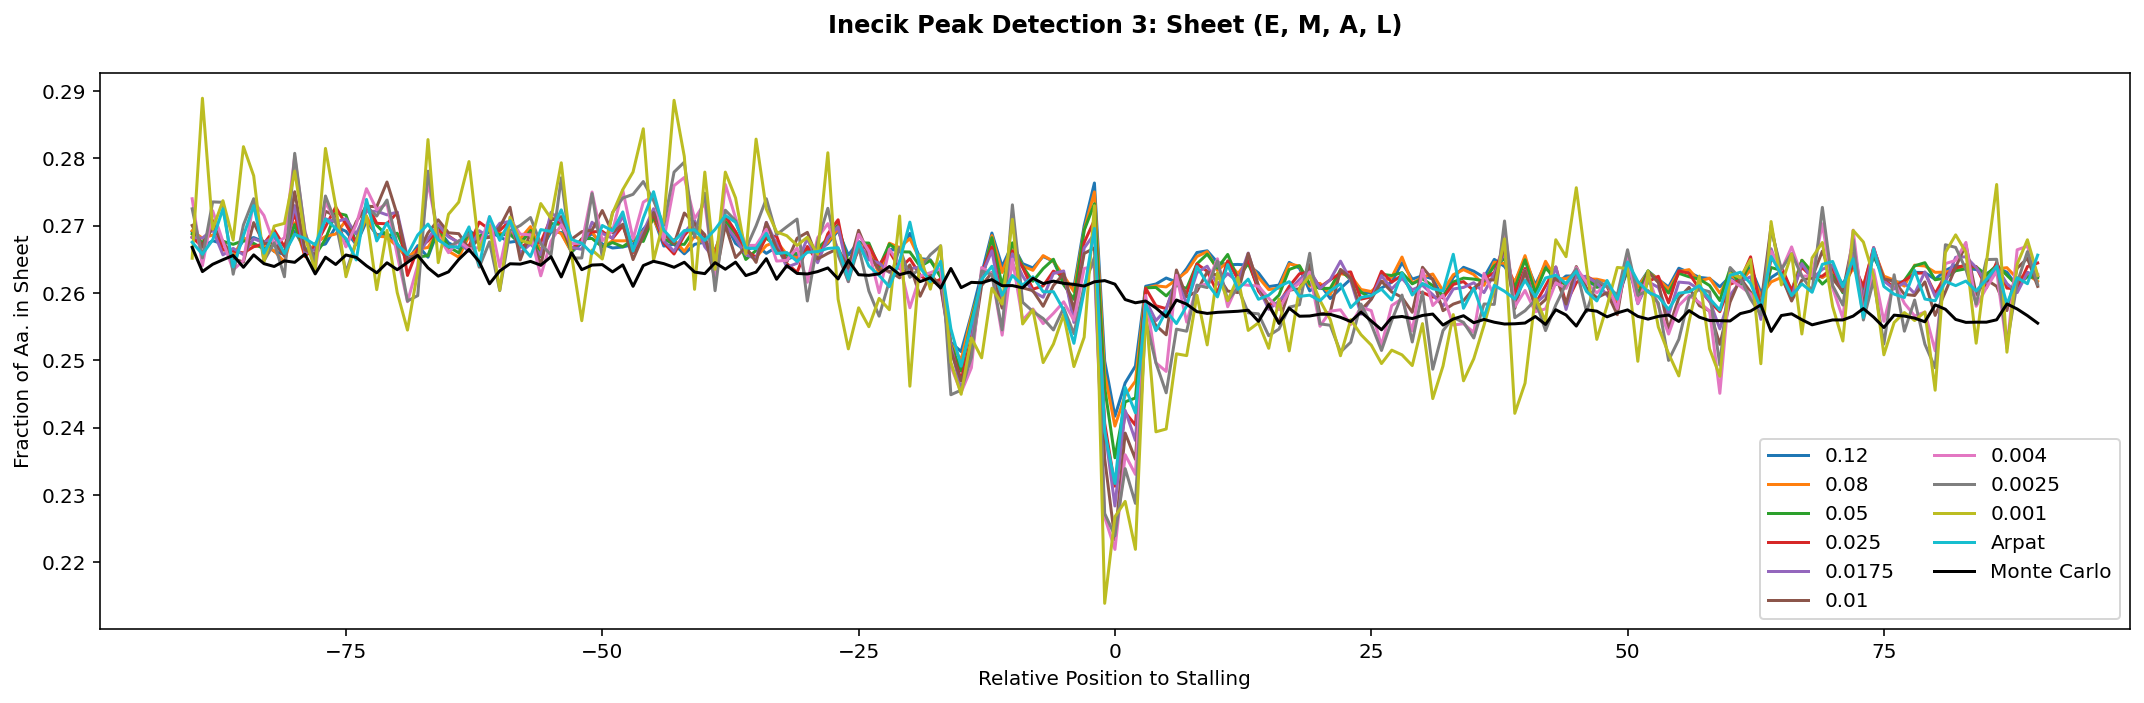

In [13]:
m = 2
aacids = [["V", "I", "Y", "F", "W", "L"], ["N", "P", "G", "S"], ["E", "M", "A", "L"]]
for ind, stracture, aacid in zip(range(3), ["Helix", "Turn", "Sheet"], aacids):
    fig = plt.figure(figsize=(15,5))
    x=np.arange(-window_flank, window_flank + 1)
    for i in range(len(percentiles)):
        plt.plot(x, np.array(ssf[m][i]).T[ind], label=percentiles[i] if m!=2 else probabilities[i])
    plt.plot(x, np.array(ssf[4]).T[ind], label="Arpat")
    plt.plot(x, np.array(ssf[5]).T[ind], label="Monte Carlo", color="black")
    plt.legend(loc="lower right", ncol=2)
    plt.title(f"Inecik Peak Detection {m+1}: {stracture} ({', '.join(aacid)})", y=1.05, fontweight="bold")
    plt.xlabel("Relative Position to Stalling")
    plt.ylabel(f"Fraction of Aa. in {stracture}")
    plt.tight_layout()
    plt.savefig(f"secondary_window{stracture}.pdf")
    plt.show()

## Amino Acid residues

In [14]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def aa_probs(mm="P"):
    # Inecik Methods
    proline = list()
    for k in range(4):
        proline_method = list()
        for i in range(len(percentiles)):
            proline_temp = list()
            W_temp = W[k][i].T
            for j in range(window_len):    
                aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
                pa = ProteinAnalysis(aminoacids_vertical)
                average_proline = pa.get_amino_acids_percent()[mm]
                proline_temp.append(average_proline)
            proline_method.append(proline_temp)
        proline.append(proline_method)
    # Arpat & Monte Carlo
    for k in range(4, 6):
        proline_temp = list()
        W_temp = W[k].T
        for j in range(window_len):
            aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
            pa = ProteinAnalysis(aminoacids_vertical)
            average_proline = pa.get_amino_acids_percent()[mm]
            proline_temp.append(average_proline)
        proline.append(proline_temp)
    return proline
    
aa = ['C', 'D', 'S', 'Q', 'K', 'I', 'P', 'T', 'F', 'N', 'G', 'H', 'L', 'R', 'W', 'A', 'V', 'E', 'Y', 'M']
save_metadata_path = os.path.join(temp_repo_dir, "jupyter_method_comparison_amino_acid_probabilities.joblib")
try:  # Because it takes very long, as written very inefficiently.
    aad = joblib.load(save_metadata_path)
except FileNotFoundError:
    executor = multiprocessing.Pool(len(aa))
    result = executor.map(aa_probs, aa)
    executor.terminate()
    executor.join()
    aad = dict(zip(aa, result))
    joblib.dump(aad, save_metadata_path);

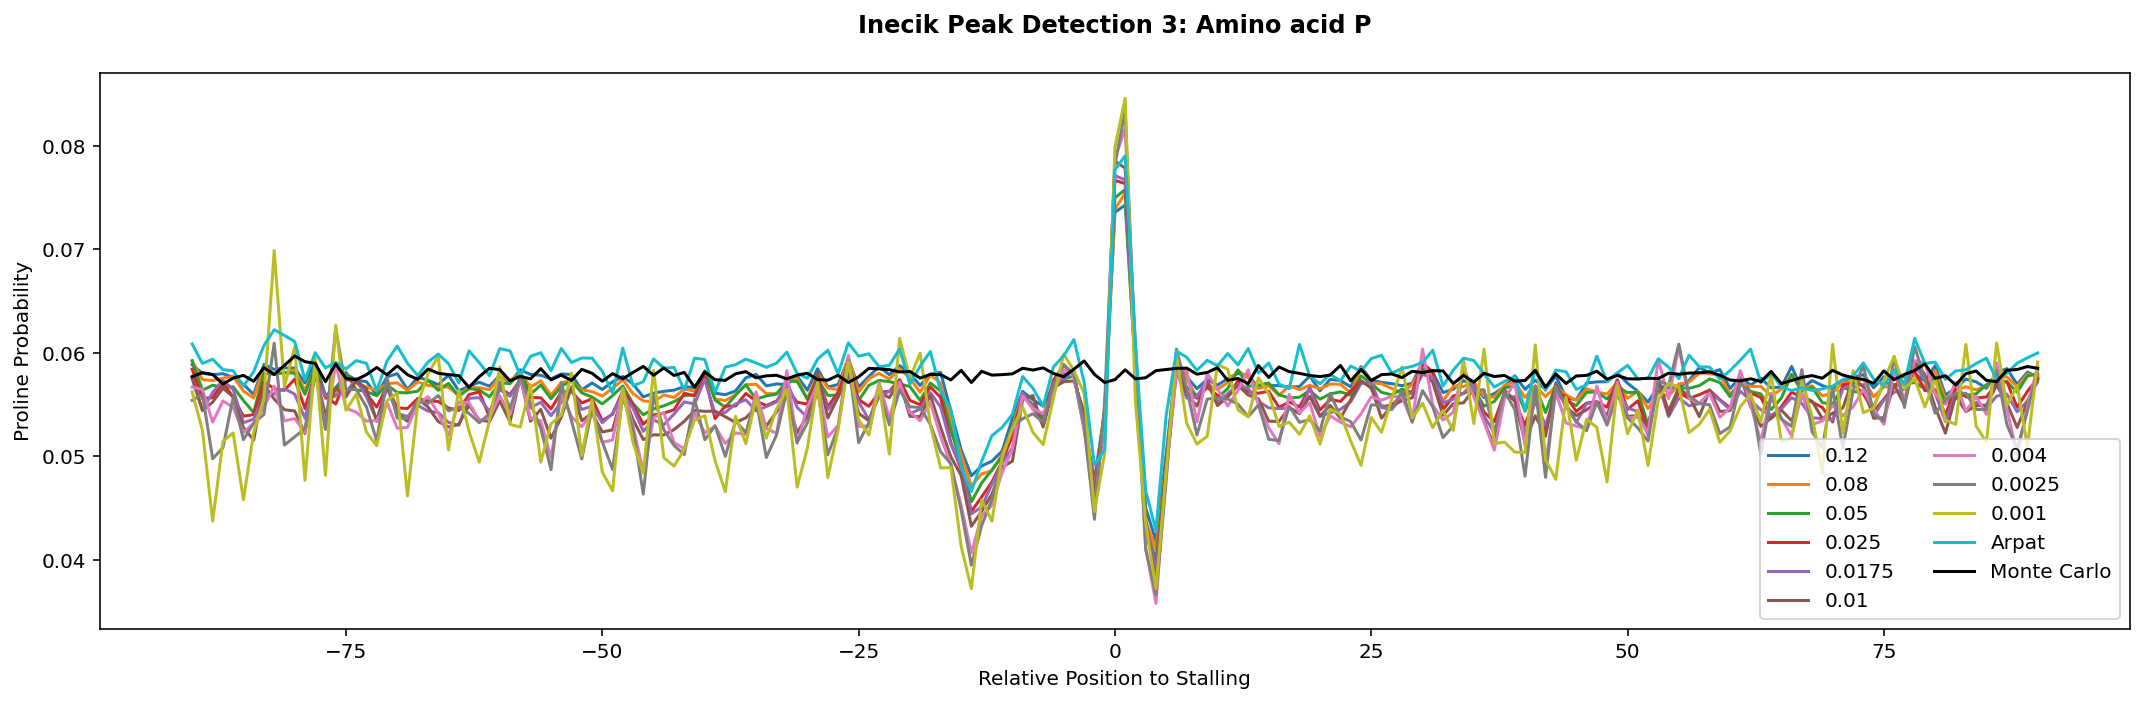

In [15]:
mm = "P"
m = 2
fig = plt.figure(figsize=(15,5))
x = np.arange(-window_flank, window_flank + 1)
for i in range(len(percentiles)):
    plt.plot(x, aad[mm][m][i], label=percentiles[i] if m!=2 else probabilities[i])
plt.plot(x, aad[mm][4], label="Arpat")
plt.plot(x, aad[mm][5], label="Monte Carlo", color="black")
plt.legend(loc="lower right", ncol=2)
plt.title(f"Inecik Peak Detection {m+1}: Amino acid {mm}", y=1.05, fontweight="bold")
plt.xlabel("Relative Position to Stalling")
plt.ylabel("Proline Probability")
plt.tight_layout()
plt.savefig("Proline_window.pdf")
plt.show()

In [16]:
# More accurate objective function

# https://en.wikipedia.org/wiki/Position_weight_matrix
def information_content(aad, inecik_method, perc):  # Relative entropy
    ic = 0
    for mm in aa:  
        observed = np.array(aad[mm][inecik_method][perc])
        expected = np.array(aad[mm][-1])
        ic += - np.log(expected/observed) * observed
    return ic

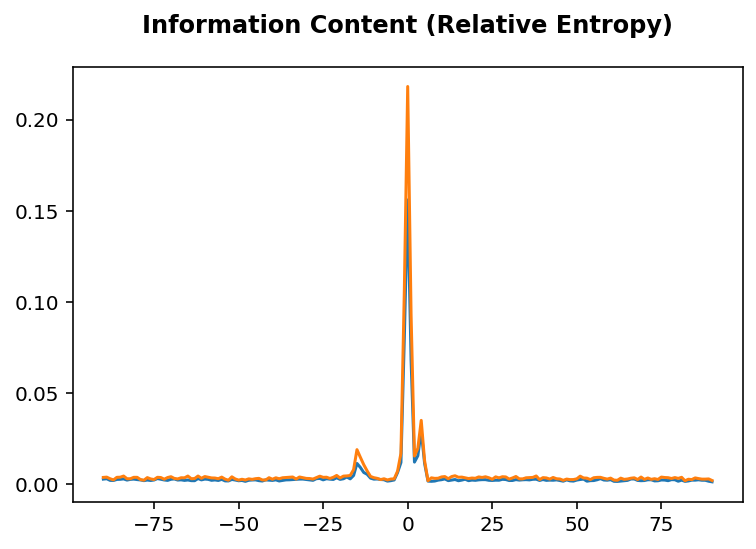

In [17]:
plt.plot(x, information_content(aad, 2, 2))
plt.plot(x, information_content(aad, 2, 5))
plt.title("Information Content (Relative Entropy)", y=1.05, fontweight="bold")
plt.savefig("information_content.pdf")
plt.show()

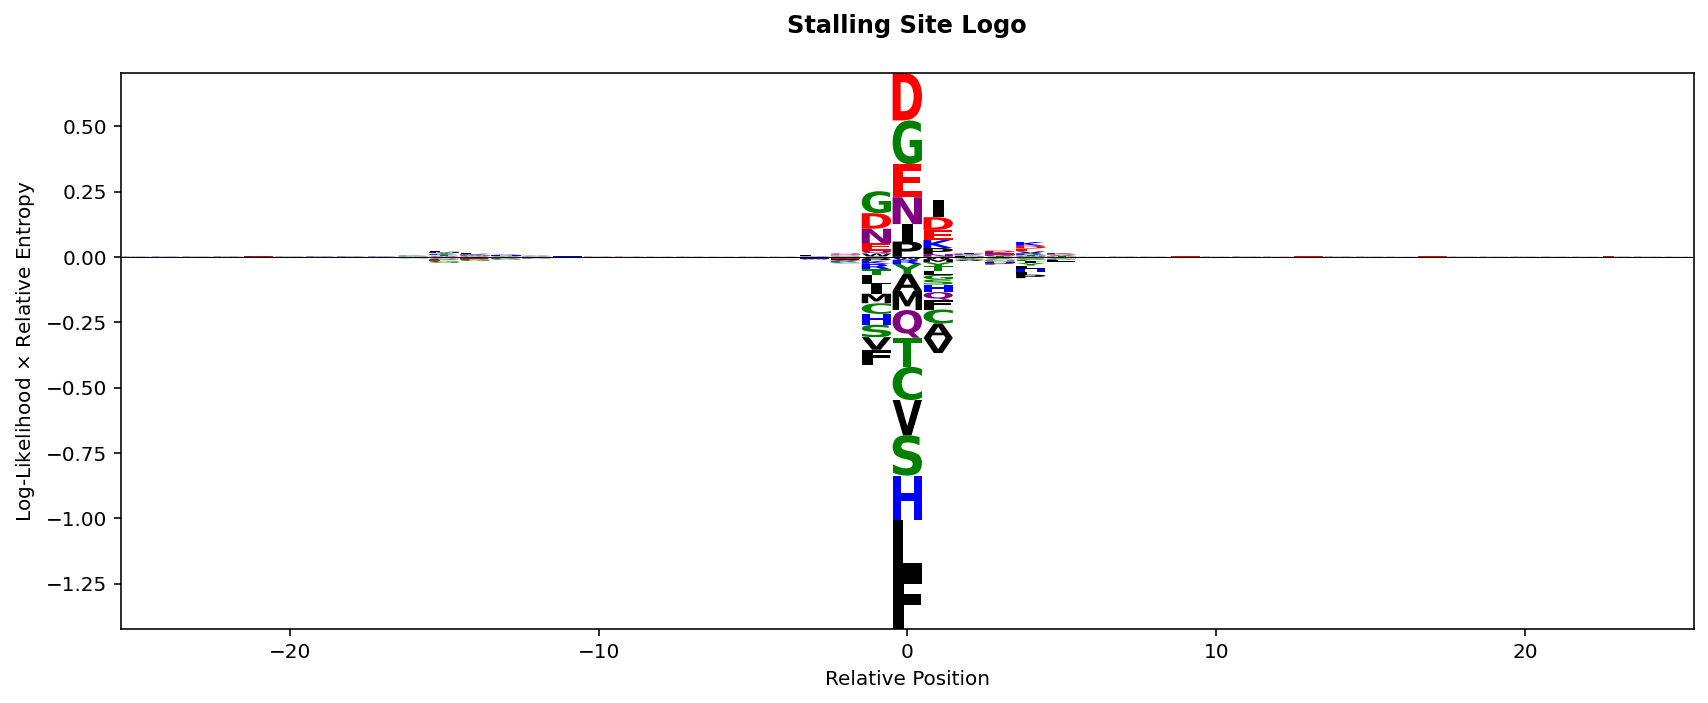

In [18]:
import logomaker
mmaa = list()
method_number = 2
ic = information_content(aad, method_number, percentiles.index(90))
for mm in aa:
    observed = np.array(aad[mm][method_number][percentiles.index(90)])
    expected = np.array(aad[mm][5])
    position_weight_matrix = ic * np.log(observed/expected)
    mmaa.append(position_weight_matrix)
    # http://www.bioinformatics.org/blogo/help.htm
    # https://en.wikipedia.org/wiki/Sequence_logo
    # https://en.wikipedia.org/wiki/Position_weight_matrix
ww_df = pd.DataFrame.from_dict(dict(zip(aa, mmaa)))
ww_df.index = np.arange(-window_flank, window_flank + 1)

# Plot
ww_df=ww_df.loc[-25: 25]
fig, ax = plt.subplots(1,1,figsize=[12,5])
ss_logo = logomaker.Logo(ww_df, flip_below=False, color_scheme='chemistry', ax=ax)
ss_logo.ax.set_ylabel(r"Log-Likelihood $\times$ Relative Entropy")
ss_logo.ax.set_xlabel("Relative Position")
ss_logo.ax.set_title("Stalling Site Logo", y=1.05, fontweight="bold")
plt.tight_layout()
plt.savefig("Logo_info_2ll.pdf")
plt.show()

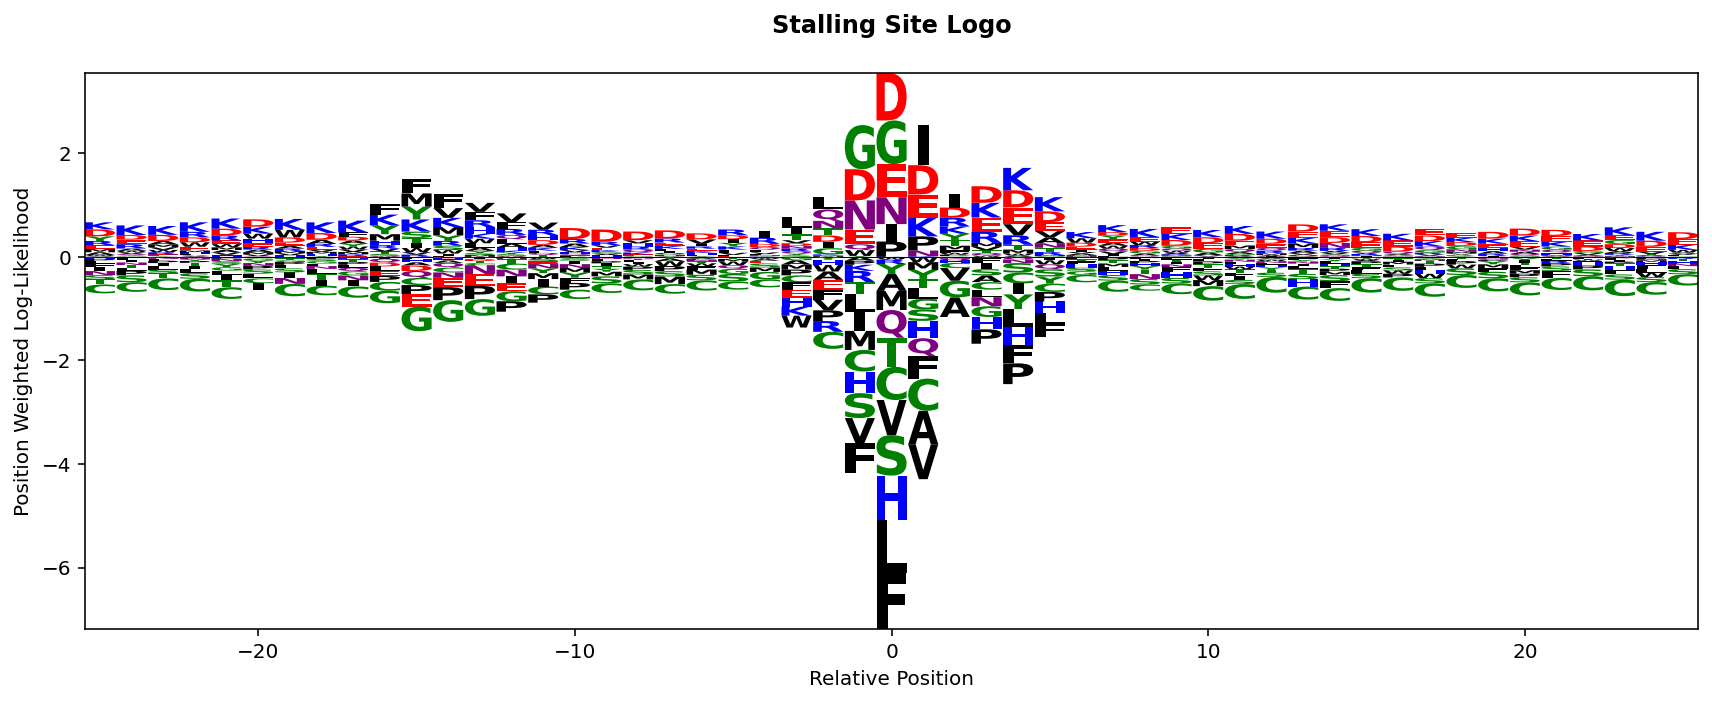

In [19]:
mmaa = list()
for mm in aa:
    observed = np.array(aad[mm][method_number][percentiles.index(90)])
    expected = np.array(aad[mm][5])
    position_weight_matrix = np.log(observed/expected)
    mmaa.append(position_weight_matrix)
    # http://www.bioinformatics.org/blogo/help.htm
    # https://en.wikipedia.org/wiki/Sequence_logo
    # https://en.wikipedia.org/wiki/Position_weight_matrix
ww_df = pd.DataFrame.from_dict(dict(zip(aa, mmaa)))
ww_df.index = np.arange(-window_flank, window_flank + 1)

# Plot
ww_df=ww_df.loc[-25: 25]
fig, ax = plt.subplots(1,1,figsize=[12,5])
ss_logo = logomaker.Logo(ww_df, flip_below=False, color_scheme='chemistry', ax=ax)
ss_logo.ax.set_ylabel(r"Position Weighted Log-Likelihood")
ss_logo.ax.set_xlabel("Relative Position")
ss_logo.ax.set_title("Stalling Site Logo", y=1.05, fontweight="bold")
plt.tight_layout()
plt.savefig("Logo_2ll.pdf")
plt.show()

## Method comparison with relative entropy as objective function

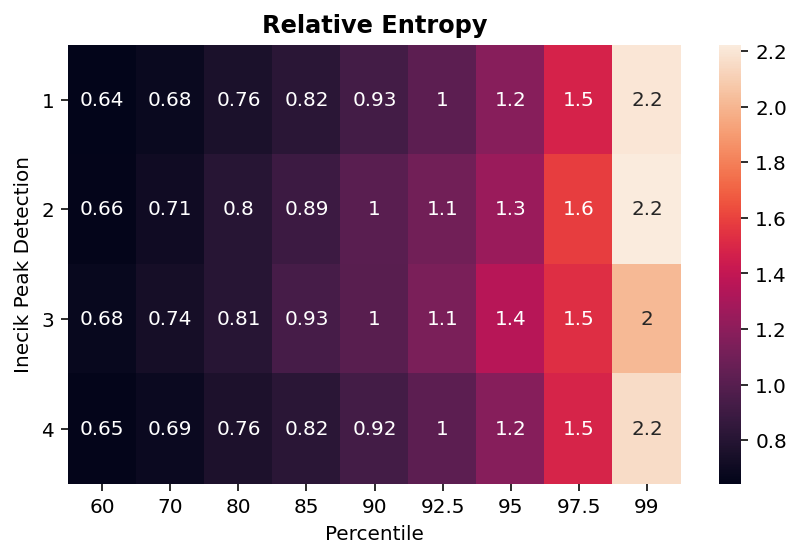

In [20]:
rel_ent = np.zeros((4,len(percentiles)))
for i1 in range(4):
    for i2 in range(len(percentiles)):
        rel_ent[i1, i2] = np.sum(information_content(aad, i1, i2))

import seaborn as sns
heat = sns.heatmap(rel_ent, annot=True, xticklabels=percentiles)
plt.gca().set_yticklabels(range(1,5), rotation=0)
plt.title("Relative Entropy", y=1.1, fontweight="bold")
plt.xlabel("Percentile")
plt.ylabel("Inecik Peak Detection")
plt.tight_layout()
plt.savefig("heatmap_method_comparison.pdf")
plt.show()

## Polarity

In [21]:
# Science 185:862-864(1974).
# https://web.expasy.org/protscale/pscale/PolarityGrantham.html
polarity_dict = {"A":  8.100, "R": 10.500, "N": 11.600, "D": 13.000, "C":  5.500, 
                 "Q": 10.500, "E": 12.300, "G":  9.000, "H": 10.400, "I":  5.200, 
                 "L":  4.900, "K": 11.300, "M":  5.700, "F":  5.200, "P":  8.000, 
                 "S":  9.200, "T":  8.600, "W":  5.400, "Y":  6.200, "V":  5.900}
aa = ['C', 'D', 'S', 'Q', 'K', 'I', 'P', 'T', 'F', 'N', 'G', 'H', 'L', 'R', 'W', 'A', 'V', 'E', 'Y', 'M']

In [22]:
# Inecik Methods
polarity = list()
for k in range(4):
    polarity_method = list()
    for i in range(len(percentiles)):
        polarity_temp = np.sum([np.array(aad[mm][k][i]) * polarity_dict[mm] for mm in aa], axis=0)
        polarity_method.append(polarity_temp)
    polarity.append(polarity_method)
# Arpat & Monte Carlo
for k in range(4, 6):
    polarity_temp = np.sum([np.array(aad[mm][k]) * polarity_dict[mm] for mm in aa], axis=0)
    polarity.append(polarity_temp)

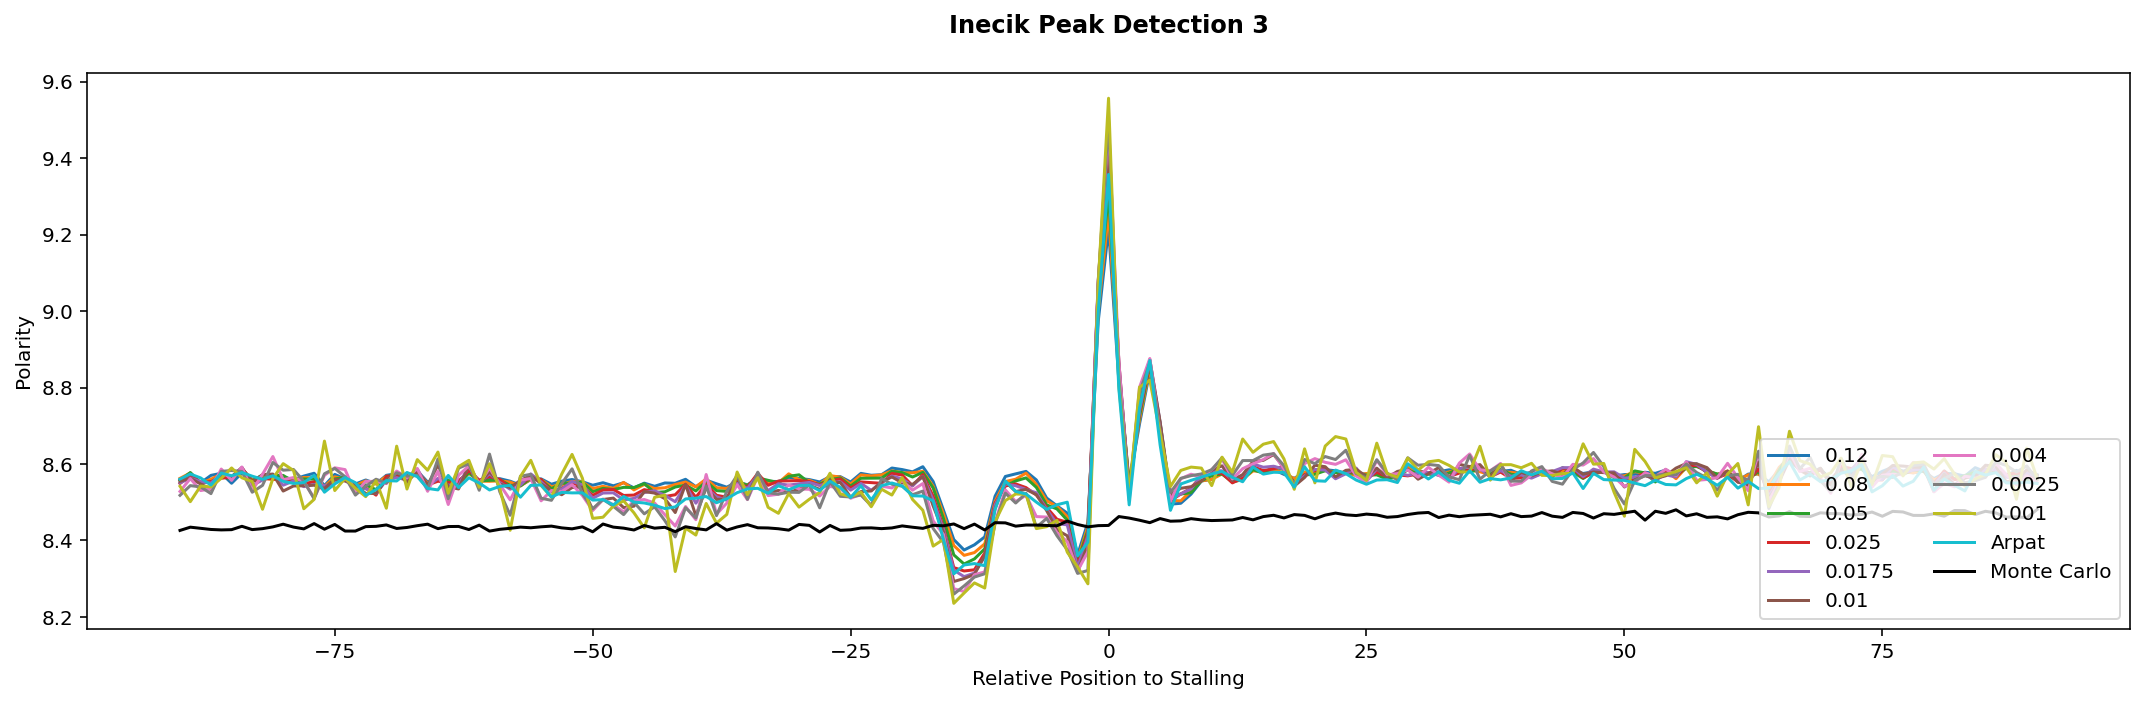

In [23]:
m = 2
fig = plt.figure(figsize=(15,5))
x=np.arange(-window_flank, window_flank + 1)
for i in range(len(percentiles)):
    plt.plot(x, polarity[m][i], label=percentiles[i] if m!=2 else probabilities[i])
plt.plot(x, polarity[4], label="Arpat")
plt.plot(x, polarity[5], label="Monte Carlo", color="black")
plt.legend(loc="lower right", ncol=2)
plt.title(f"Inecik Peak Detection {m+1}", y=1.05, fontweight="bold")
plt.xlabel("Relative Position to Stalling")
plt.ylabel("Polarity")
plt.tight_layout()
plt.savefig("polarity_window.pdf")
plt.show()

## Flexibility

In [24]:
# Science 185:862-864(1974).
# https://web.expasy.org/protscale/pscale/PolarityGrantham.html
flexibility_dict = {"A":  0.360, "R":  0.530, "N":  0.460, "D":  0.510, "C":  0.350, 
                 "Q":  0.490, "E":  0.500, "G":  0.540, "H":  0.320, "I":  0.460, 
                 "L":  0.370, "K":  0.470, "M":  0.300, "F":  0.310, "P":  0.510, 
                 "S":  0.510, "T":  0.440, "W":  0.310, "Y":  0.420, "V":  0.390}
aa = ['C', 'D', 'S', 'Q', 'K', 'I', 'P', 'T', 'F', 'N', 'G', 'H', 'L', 'R', 'W', 'A', 'V', 'E', 'Y', 'M']

In [25]:
# Inecik Methods
flexibility = list()
for k in range(4):
    flexibility_method = list()
    for i in range(len(percentiles)):
        flexibility_temp = np.sum([np.array(aad[mm][k][i]) * flexibility_dict[mm] for mm in aa], axis=0)
        flexibility_method.append(flexibility_temp)
    flexibility.append(flexibility_method)
# Arpat & Monte Carlo
for k in range(4, 6):
    flexibility_temp = np.sum([np.array(aad[mm][k]) * flexibility_dict[mm] for mm in aa], axis=0)
    flexibility.append(flexibility_temp)

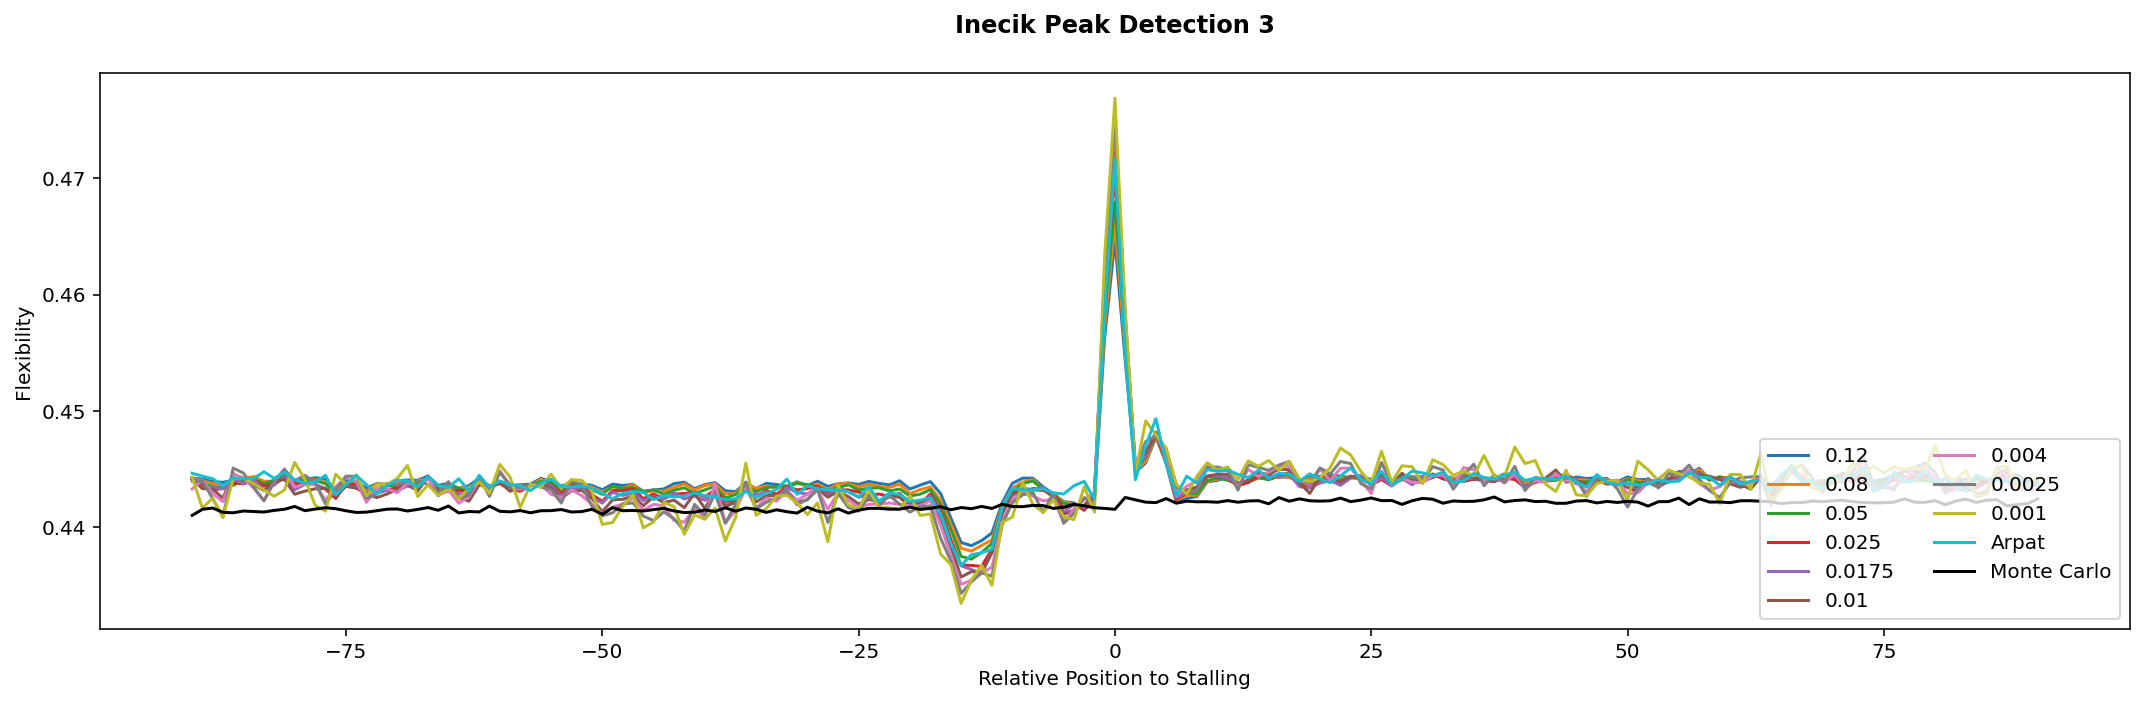

In [26]:
m = 2
fig = plt.figure(figsize=(15,5))
x=np.arange(-window_flank, window_flank + 1)
for i in range(len(percentiles)):
    plt.plot(x, flexibility[m][i], label=percentiles[i] if m!=2 else probabilities[i])
plt.plot(x, flexibility[4], label="Arpat")
plt.plot(x, flexibility[5], label="Monte Carlo", color="black")
plt.legend(loc="lower right", ncol=2)
plt.title(f"Inecik Peak Detection {m+1}", y=1.05, fontweight="bold")
plt.xlabel("Relative Position to Stalling")
plt.ylabel("Flexibility")
plt.tight_layout()
plt.savefig("Flexibility_window.pdf")
plt.show()

## Best Percentile

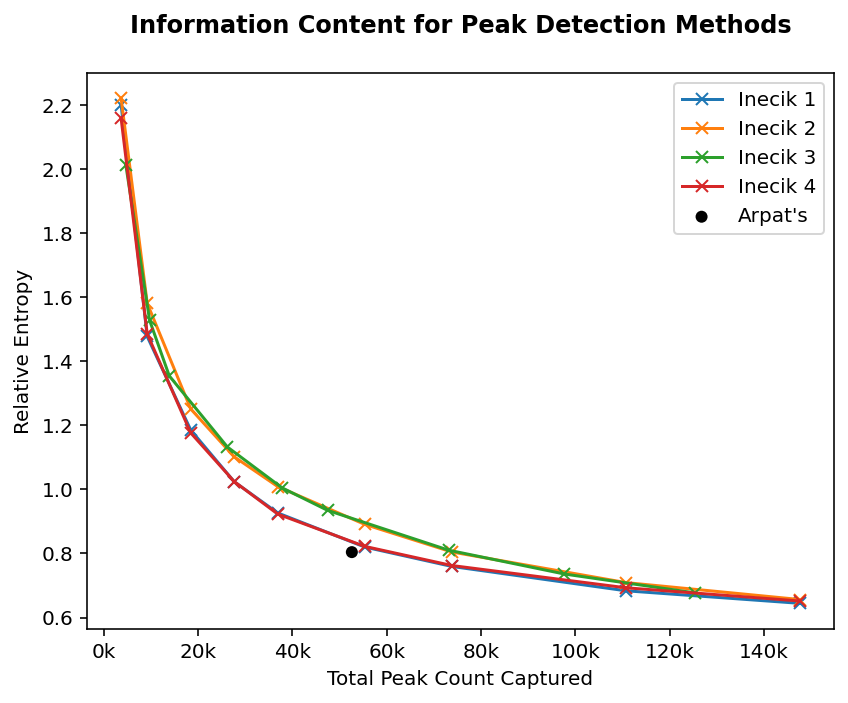

In [27]:
def information_content_arpat(aad):  # Relative entropy
    ic = 0
    for mm in aa:  
        observed = np.array(aad[mm][-2])
        expected = np.array(aad[mm][-1])
        ic += - np.log(expected/observed) * observed
    return ic

fig = plt.figure(figsize=(6, 5))
for m in range(4):
    lengths = [len(W[m][i]) for i in range(len(percentiles))]
    score = [np.sum(information_content(aad, m, k)) for k in range(len(percentiles))]
    plt.plot(lengths, score, marker="x", label=f"Inecik {m+1}")
arpat_score = np.sum(information_content_arpat(aad))
arpat_length = len(W[4])
plt.scatter(arpat_length, arpat_score, edgecolors="None", label="Arpat's", color="black")
plt.title(f"Information Content for Peak Detection Methods", y=1.05, fontweight="bold")
plt.xlabel("Total Peak Count Captured")
plt.ylabel("Relative Entropy")
plt.gca().set_xticklabels(['{:,.0f}'.format(x) + 'k' for x in plt.gca().get_xticks()/1000])
plt.legend()
plt.tight_layout()
plt.savefig("best_percentile_curves.pdf")
plt.show()

## Scanning wlen and percentile for Inecik 2

In [28]:
from functools import partial
from copy import deepcopy

window_len = 181
window_flank = int(np.floor(window_len / 2))
percentiles_wlen = (70, 80, 85, 90, 92.5, 95, 97.5, 99)
wlens = (10, 15, 20, 30, 50, 150, 500, 1000)
assert window_len % 2 == 1 and window_len >= 3

# Methods
inecik2 = partial(I.riboseq_sixtymers.stalling_peaks_inecik_2, window="hanning", window_len=25, min_rpkm_sixtymers=-1, min_rpkm_translatome=1)

save_metadata_path = os.path.join(temp_repo_dir, "jupyter_method_comparison_protein_sequences_params_wlen_percentile_inecik2.joblib")
try:  # Because it takes very long, as written very inefficiently.
    W_wlen = joblib.load(save_metadata_path)
except FileNotFoundError:
    gene_list_calc = I.gene_list
    counter = 0
    total_iteration = (len(wlens)) * (len(gene_list_calc))
    windows = [[[] for _ in range(len(percentiles_wlen))] for _ in range(len(wlens))] + [[]]   # inecik1, monte_carlo
    for ind1, wlen in enumerate(wlens):
        for ind3, gene_id in enumerate(gene_list_calc):
            counter += 1
            if counter % 1000 == 1:
                progress_bar(counter, total_iteration, verbose=True, suffix=f"    wlen {ind1 + 1}: {wlen}")
            best_transcript = I.gene_info[gene_id].transcripts.iloc[0][0]  # At least 1 transcript exists
            protein_sequence = I.protein_genome.db[best_transcript][1]
            length_protein = len(protein_sequence)
            assert "." not in protein_sequence
            protein_sequence = "." * window_flank + protein_sequence + "." * window_flank
            # My method
            for ind2, perc in enumerate(percentiles_wlen):
                peaks2 = (np.floor(inecik2(gene_id, percentile=perc, wlen=wlen) / 3) + window_flank).astype(int)
                for peak in peaks2:
                    windows[ind1][ind2].append(protein_sequence[peak - window_flank: peak + window_flank + 1])
            if ind1 == 0:
                # Monte Carlo
                peaks_mc = (np.sort(np.random.choice(length_protein, 10)) + window_flank).astype(int)
                for peak in peaks_mc:
                    windows[-1].append(protein_sequence[peak - window_flank: peak + window_flank + 1])
    # Convert to chararray
    W_wlen = [[None for _ in range(len(percentiles_wlen))] for _ in range(len(wlens))] + [None]
    for wle in range(len(wlens)):
        for per in range(len(percentiles_wlen)):
            W_temp = np.chararray((len(windows[wle][per]), window_len), itemsize=1)
            W_temp[:] = "."
            for ind, peak_window in enumerate(windows[wle][per]):
                W_temp[ind] = list(peak_window)
            W_wlen[wle][per] = W_temp
    # Monte Carlo
    W_temp = np.chararray((len(windows[-1]), window_len), itemsize=1)
    W_temp[:] = "."
    for ind, peak_window in enumerate(windows[-1]):
        W_temp[ind] = list(peak_window)
    W_wlen[-1] = W_temp
    # Return
    del windows
    joblib.dump(W_wlen, save_metadata_path)

In [29]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def aa_probs_wlen(mm="P"):
    # Inecik Methods
    proline = list()
    for k in range(len(wlens)):
        proline_method = list()
        for i in range(len(percentiles_wlen)):
            proline_temp = list()
            W_temp = W_wlen[k][i].T
            for j in range(window_len):    
                aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
                pa = ProteinAnalysis(aminoacids_vertical)
                average_proline = pa.get_amino_acids_percent()[mm]
                proline_temp.append(average_proline)
            proline_method.append(proline_temp)
        proline.append(proline_method)
    # Monte Carlo
    proline_temp = list()
    W_temp = W_wlen[-1].T
    for j in range(window_len):
        aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
        pa = ProteinAnalysis(aminoacids_vertical)
        average_proline = pa.get_amino_acids_percent()[mm]
        proline_temp.append(average_proline)
    proline.append(proline_temp)
    return proline

aa = ['C', 'D', 'S', 'Q', 'K', 'I', 'P', 'T', 'F', 'N', 'G', 'H', 'L', 'R', 'W', 'A', 'V', 'E', 'Y', 'M']
save_metadata_path = os.path.join(temp_repo_dir, "jupyter_method_comparison_amino_acid_probabilities_wlen_scan.joblib")
try:  # Because it takes very long, as written very inefficiently.
    aad_wlen = joblib.load(save_metadata_path)
except FileNotFoundError:
    executor = multiprocessing.Pool(len(aa))
    result = executor.map(aa_probs_wlen, aa)
    executor.terminate()
    executor.join()
    aad_wlen = dict(zip(aa, result))
    joblib.dump(aad_wlen, save_metadata_path);

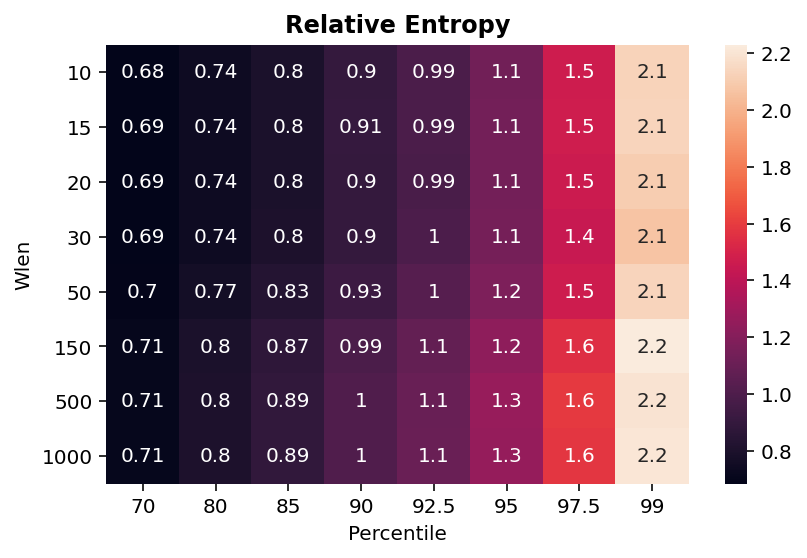

In [30]:
import seaborn as sns
rel_ent = np.zeros((len(wlens),len(percentiles_wlen)))
for i1 in range(len(wlens)):
    for i2 in range(len(percentiles_wlen)):
        rel_ent[i1, i2] = np.sum(information_content(aad_wlen, i1, i2))
        
heat_wlen = sns.heatmap(rel_ent, annot=True, xticklabels=percentiles_wlen)
plt.gca().set_yticklabels(wlens, rotation=0)
plt.title("Relative Entropy", y=1.1, fontweight="bold")
plt.xlabel("Percentile")
plt.ylabel("Wlen")
plt.tight_layout()
plt.savefig("percentile_wlen_scan.pdf")
plt.show()

In [31]:
# analayse the regions 92.5-95 arası gibi to pinpoint important peaks

In [32]:
# GERP Score